# Inicialização

In [75]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  torch.optim as optim
import  psutil
import  os
import  time
import  joblib
import  json
import  warnings
import  pandas as pd
import  seaborn as sns
import  snap7
import  ctypes
import  numpy as np
import  matplotlib.pyplot as plt

from    torch.utils.data import DataLoader, TensorDataset
from    torch.cuda.amp import GradScaler, autocast
from    sklearn.model_selection import train_test_split
from    sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from    sklearn.ensemble import RandomForestClassifier
from    sklearn.preprocessing import LabelEncoder
from    sklearn.model_selection import GridSearchCV
from    sklearn.preprocessing import StandardScaler
from    sklearn.preprocessing import MinMaxScaler
from    sklearn.model_selection import ParameterGrid
#from   snap7.types import Areas, S7DataItem, S7WLWord, S7WLReal, S7WLTimer
from    snap7.type import S7DataItem, Area, WordLen
from    snap7.util import set_int, set_real, get_int, get_real, get_s5time
from    imblearn.over_sampling import SMOTE
from    imblearn.under_sampling import RandomUnderSampler
from    imblearn.pipeline import Pipeline
from    imblearn.combine import SMOTETomek

warnings.filterwarnings("ignore")

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


# Carregar e Preparar Conjunto de Dados

In [76]:
# dados importados da plataforma KAGGLE - https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
df = pd.read_csv("predictive_maintenance.csv")
df.head()


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


* descartar as colunas desnecessárias

In [77]:
df=df.drop(['Product ID','UDI','Target'],axis=1)

* codificar a coluna de falhas para tipo int entre 0 e 5

In [78]:
label_encoder = LabelEncoder()

# Perform label encoding
df['Failure Type_encoded'] = label_encoder.fit_transform(df['Failure Type'])

df['Failure Type_encoded'].value_counts()

''''
0 - 112  - heat dissipation
1 - 9652 - no Failure
2 - 78   - overstrain
3 - 95   - power failure
4 - 18   - random failure
5 - 45   - tool wear
'''


"'\n0 - 112  - heat dissipation\n1 - 9652 - no Failure\n2 - 78   - overstrain\n3 - 95   - power failure\n4 - 18   - random failure\n5 - 45   - tool wear\n"

* converter a coluna 'Type' (string) em outras duas separadas do tipo bool (uma para cada tipo de material) 

In [79]:
df = pd.get_dummies(df, columns=['Type'], prefix='Type', drop_first=True)
df.head()


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure Type,Failure Type_encoded,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,No Failure,1,False,True
1,298.2,308.7,1408,46.3,3,No Failure,1,True,False
2,298.1,308.5,1498,49.4,5,No Failure,1,True,False
3,298.2,308.6,1433,39.5,7,No Failure,1,True,False
4,298.2,308.7,1408,40.0,9,No Failure,1,True,False


* separar os dados em: dados de entrada (features), X  e dados de saída (label), y

In [93]:
# Definição do conjunto de dados de entrada e do conjunto de dados de saída

X_raw = df.drop(['Failure Type','Failure Type_encoded'], axis=1).values
y_raw= df['Failure Type_encoded'].values

print(X_raw[168])
print(y_raw[168])


[298.4 308.3 1433 62.3 20 True False]
3


* Em aplicações do mundo real, a modelagem de classificação frequentemente enfrenta o problema de conjuntos de dados desequilibrados, onde o número de instâncias da classe majoritária é muito maior do que o da classe minoritária, o que dificulta o aprendizado adequado do modelo em relação à classe minoritária. Isso se torna um problema sério quando a informação contida na classe minoritária é mais importante como, por exemplo, no conjunto utilizado.

* Uma das abordagens populares para resolver o problema de conjuntos de dados desequilibrados é a superamostragem da classe minoritária ou a subamostragem da classe majoritária. No entanto, essas abordagens possuem suas próprias limitações. No método tradicional de superamostragem, a ideia é duplicar aleatoriamente alguns exemplos da classe minoritária — essa técnica não adiciona novas informações ao conjunto de dados. Por outro lado, o método de subamostragem é realizado removendo aleatoriamente alguns exemplos da classe majoritária, o que resulta na perda de algumas informações originais dos dados.

In [94]:
print('Total de amostras antes balanceamento:',df['Failure Type_encoded'].count())
print('Total de amostras por falha:\n\n', df['Failure Type_encoded'].value_counts())

Total de amostras antes balanceamento: 10000
Total de amostras por falha:

 Failure Type_encoded
1    9652
0     112
3      95
2      78
5      45
4      18
Name: count, dtype: int64


* Uma solução para superar essas limitações é gerar novos exemplos sintetizados a partir da classe minoritária existente. Esse método é conhecido como Técnica de Superamostragem da Minoria Sintética (SMOTE). Existem muitas variações do SMOTE, mas neste artigo será explicado o método SMOTE-Tomek Links e sua implementação em Python. Esse método combina a superamostragem do SMOTE com a subamostragem dos Tomek Links.

* O método SMOTE-Tomek Links, desenvolvido por Chawla et al. (2002) é uma combinação de técnicas que visa equilibrar os dados ao aumentar a representatividade da classe minoritária através da criação de novos exemplos sintéticos e ao mesmo tempo remover exemplos que são considerados ruidosos ou redundantes na classe majoritária. A implementação desta abordagem utilizando Python é apresentada, detalhando os passos e a lógica do algoritmo, assim como os resultados obtidos em diferentes conjuntos de dados desequilibrados.

* A combinação das técnicas de superamostragem e subamostragem, especificamente utilizando o método SMOTE-Tomek Links, mostra-se eficaz na melhoria do desempenho dos modelos de classificação em conjuntos de dados desequilibrados. Esta abordagem permite ao modelo aprender de forma mais eficiente a partir da classe minoritária, mantendo a integridade e a diversidade da informação no conjunto de dados.



In [95]:
#implementação do método SMOTE no conunto de dados
smt=SMOTETomek(sampling_strategy='auto',random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_raw, y_raw)

# Convertendo para dataframe do pandas
df_resampled = pd.DataFrame(X_resampled, columns=[f'feature_{i}' for i in range(X_resampled.shape[1])])
df_resampled['Type_encoded'] = y_resampled 

df_resampled.head()

#distribuição das classes após balanceamento
print('Total de amostras após balanceamento:',df_resampled['Type_encoded'].count())
print('Total de amostras por falha:\n\n', df_resampled['Type_encoded'].value_counts())

Total de amostras após balanceamento: 57868
Total de amostras por falha:

 Type_encoded
2    9652
0    9649
5    9647
3    9645
4    9645
1    9630
Name: count, dtype: int64


In [96]:
df_resampled = df_resampled.rename(columns={'feature_0':'Temp_Ar'})
df_resampled = df_resampled.rename(columns={'feature_1':'Temp_Pr'})
df_resampled = df_resampled.rename(columns={'feature_2':'Vel_Spindle'})
df_resampled = df_resampled.rename(columns={'feature_3':'Torque'})
df_resampled = df_resampled.rename(columns={'feature_4':'Desg_Ferr'})
df_resampled = df_resampled.rename(columns={'feature_5':'Mat_L'})
df_resampled = df_resampled.rename(columns={'feature_6':'Mat_M'})

df_resampled = df_resampled.rename(columns={'Type_encoded':'Tipo_Falha'})

df_resampled.head()


,Temp_Ar,Temp_Pr,Vel_Spindle,Torque,Desg_Ferr,Mat_L,Mat_M,Tipo_Falha
0,298.1,308.6,1551.0,42.8,0.0,0.0,1.0,1
1,298.2,308.7,1408.0,46.3,3.0,1.0,0.0,1
2,298.1,308.5,1498.0,49.4,5.0,1.0,0.0,1
3,298.2,308.6,1433.0,39.5,7.0,1.0,0.0,1
4,298.2,308.7,1408.0,40.0,9.0,1.0,0.0,1


* Metodo para normalização do conjunto de dados e formatação para as diferentes redes neurais (MLP e KAN)

In [125]:
def load_Preditive_Maintenance_Dataset():

    X_ = df_resampled.drop(['Tipo_Falha'], axis="columns")
 
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_   = scaler.fit_transform(X_)    
    joblib.dump(scaler, 'minmax_scaler.pkl')  

    data_min = scaler.data_min_
    data_max = scaler.data_max_
    feature_range_min, feature_range_max = scaler.feature_range  

    print(data_min)
    print(data_max)
    print(feature_range_min)
    print(feature_range_max)


    y_ = df_resampled['Tipo_Falha']

    #convertendo os dados em tensores e atribuindo a sua excucção na CPU ou GPU (device) conforme disponibilidade avaliada no inicio do programa
    X = torch.tensor(X_, dtype = torch.float32).to(device)
    y = torch.tensor(y_.values, dtype = torch.long).to(device)  
    
    #separa os dados entre conjunto de dados para treinamento (80%) e conjunto de dados para teste/validação (20% <-> teste_size=0.2)
    train_data_, test_data_, train_target_, test_target_ = train_test_split(X, y, test_size=0.2, random_state=42)

    # geração de  mini batches para melhorar desempenho do treinamento
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_, train_target_), batch_size=10, shuffle=True)   
    validation_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data_, test_target_), batch_size=10, shuffle=False)  

    #conjunto de dados no formato a ser utilizado no redes MLP
    train_data_loader   = train_loader
    test_data_loader    = validation_loader

    train_data      = train_data_    
    test_data       = test_data_
    train_labels    = train_target_
    test_label      = test_target_
    data_min_scaler = data_min
    data_max_scaler = data_max
    feature_range_min_scaler = feature_range_min
    feature_range_max_scaler = feature_range_max

    MLP_dataset     = [ train_data,
                        train_labels,
                        test_data,
                        test_label,
                        train_data_loader,
                        test_data_loader,
                        data_min_scaler,
                        data_max_scaler,
                        feature_range_min_scaler,
                        feature_range_max_scaler ]  

    return MLP_dataset

dataset =load_Preditive_Maintenance_Dataset()

[ 295.3  305.7 1168.     3.8    0.     0.     0. ]
[3.045e+02 3.138e+02 2.886e+03 7.660e+01 2.530e+02 1.000e+00 1.000e+00]
0
1


# Implementação Rede Neural Multilayer Perceptron

In [183]:

class IndPM_MLP(nn.Module):  
    def __init__(self, layer_sizes, dropout_prob=0.5):
        super(IndPM_MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2: 
                self.dropouts.append(nn.Dropout(p=dropout_prob))
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
            x = self.dropouts[i](x)
        x = self.layers[-1](x)
        return x

def initialize_weights(model):
    for layer in model.layers:
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()

    ram_usage       = []
    cpu_usage       = []
    backprop_time   = []
    loss_list       = []

    scaler = GradScaler()

    startMLP_train = time.time()   

    for epoch in range(num_epochs):
        epoch_start = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            startMLP_bwd = time.time()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            endMLP_bwd = time.time()
            
            backprop_time.append((endMLP_bwd - startMLP_bwd) * 1000)

        loss_list.append(loss.item())

        if epoch % 32 == 0: 
            ram_usage.append(psutil.virtual_memory().percent)
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

        epoch_end = time.time()
        epoch_duration = epoch_end - epoch_start

        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {round(loss.item(), 4)} | Epoch Duration: {round(epoch_duration, 2)} s | Backpropagation Time: {round(np.mean(backprop_time), 2)} ms | CPU Usage: {round(cpu_usage[-1], 2)} % | RAM Usage: {round(ram_usage[-1], 2)} %', end="\r")

    endMLP_train = time.time()
   
    train_time = endMLP_train - startMLP_train
    backpropagation_time = np.mean(backprop_time)
    max_cpu_usage = np.max(cpu_usage)   
    max_ram_usage = np.max(ram_usage)
    min_loss = np.min(loss_list)

    info = {
        'Num_Epochs': num_epochs,
        'Epoch_train_time': epoch_duration,
        'Back_Propagation_Time': backpropagation_time,
        'Max_CPU_usage': max_cpu_usage,
        'Max_RAM_usage': max_ram_usage,
        'Train_Time': train_time,
        'Min_Lost': min_loss     }
    return info

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    
    # Calculando F1-Score, Precision e Recall
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    # Calculando a Matriz de Confusão
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Retornando todas as métricas em um dicionário
    metrics = {
        'Accuracy': accuracy,
        'F1_Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Confusion_Matrix': conf_matrix
    }
    
    return metrics

In [184]:

layers = [7, 128,64,32, 6] 
modelMLP = IndPM_MLP(layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelMLP.parameters(), lr=0.001)



In [185]:

mlp_train_results = train(modelMLP, dataset[4], criterion, optimizer, num_epochs=3, device=device)

test_model(modelMLP, dataset[5],device=device)

{'Accuracy': 90.03801624330396,
 'F1_Score': 0.8957501703439968,
 'Precision': 0.9072770558428681,
 'Recall': 0.9003801624330395,
 'Confusion_Matrix': array([[1877,    0,   14,    3,    0,    0],
        [  41, 1142,   38,   46,  513,  172],
        [   2,    0, 1904,    0,    0,    1],
        [   5,    0,   57, 1910,   20,    3],
        [   0,  107,    2,    0, 1750,   28],
        [   0,    0,   28,    0,   73, 1838]])}

INFERÊNCIA

In [ ]:
def connect_to_plc(ip, rack, slot):
    plc = snap7.client.Client()
    plc.connect(ip, rack, slot)
    if plc.get_connected():
        print("Conectado ao CLP")
        return plc
    else:
        print("Falha na conexão com o CLP")
        return None

def read_multiple_floats(plc, db_number, start_address, num_values):
    data = []
    for i in range(num_values):
        data.append(get_real(plc.db_read(db_number, start_address + i * 4, 4), 0))
    return data

def write_multiple_floats(plc, db_number, start_address, values):
    for i, value in enumerate(values):
        data = bytearray(4)
        set_real(data, 0, value)
        plc.db_write(db_number, start_address + i * 4, data)

# Configurações de conexão
ip = '192.168.0.1'  # IP do CLP
rack = 0  # Rack do CLP
slot = 1  # Slot do CLP
db_number = 2  # Número do DB onde os dados estão armazenados
start_address = 0  # Endereço inicial

In [202]:

scaler = joblib.load('minmax_scaler.pkl')
modelMLP.eval()  

# Conectando ao CLP
plc = connect_to_plc(ip, rack, slot)

df = pd.DataFrame(columns=[
    'Ciclo', 
    'Tempo_Total_Previsao', 
    'Tempo_Leitura', 
    'Tempo_Previsao_Rede', 
    'Tempo_Escrita', 
    'Entradas', 
    'Saidas'
])

ciclo = 0  # Contador de ciclos

while True:  # Exemplo de loop infinito; substitua conforme necessário
    ciclo += 1
    start_time1 = time.time()

    start_time2 = time.time()
    inputs = read_multiple_floats(plc, 2, 0, 7)
    end_time2 = time.time()

    inputs_2D = [inputs]
    scaled_input = scaler.transform(inputs_2D)

    input_tensor = torch.tensor([scaled_input], dtype=torch.float32)

    start_time3 = time.time()
    with torch.no_grad():
        # Fazendo a previsão
        output = modelMLP(input_tensor)
    end_time3 = time.time()

    # Escrevendo as 6 saídas de volta no DB
    output_values = F.softmax(output, dim=2).squeeze().tolist()

    start_time4 = time.time()
    write_start_address = 0  
    write_multiple_floats(plc, 3, write_start_address, output_values)
    end_time4 = time.time()

    end_time1 = time.time()

    # Calculando os tempos
    previsao_total = end_time1 - start_time1
    tempo_leitura = end_time2 - start_time2 
    tempo_previsao_rede = end_time3 - start_time3 
    tempo_escrita = end_time4 - start_time4

    # Criando um DataFrame para a nova linha
    new_row = pd.DataFrame([{
        'Ciclo': ciclo,
        'Tempo_Total_Previsao': previsao_total,
        'Tempo_Leitura': tempo_leitura,
        'Tempo_Previsao_Rede': tempo_previsao_rede,
        'Tempo_Escrita': tempo_escrita,
        'Entradas': inputs,
        'Saidas': output_values
    }])

    # Concatenando a nova linha ao DataFrame existente
    df = pd.concat([df, new_row], ignore_index=True)

    # Exemplo de condição para sair do loop (substitua conforme necessário)
    if ciclo == 10000:  # Armazene 100 ciclos, por exemplo
        break

print(df.describe())

# Salvando os resultados em um arquivo CSV para análise posterior
df.to_csv('resultados_previsao.csv', index=False)

# Desconectando do CLP
plc.disconnect()
print("Desconectado do CLP")


Conectado ao CLP
       Tempo_Total_Previsao  Tempo_Leitura  Tempo_Previsao_Rede  Tempo_Escrita
count          10000.000000   10000.000000         10000.000000   10000.000000
mean               0.023682       0.012643             0.000228       0.010495
std                0.004026       0.002795             0.000059       0.002602
min                0.014977       0.007722             0.000174       0.006611
25%                0.020833       0.010392             0.000192       0.008799
50%                0.023348       0.012408             0.000200       0.010181
75%                0.026371       0.014485             0.000241       0.012218
max                0.039765       0.025775             0.000781       0.024155
Desconectado do CLP


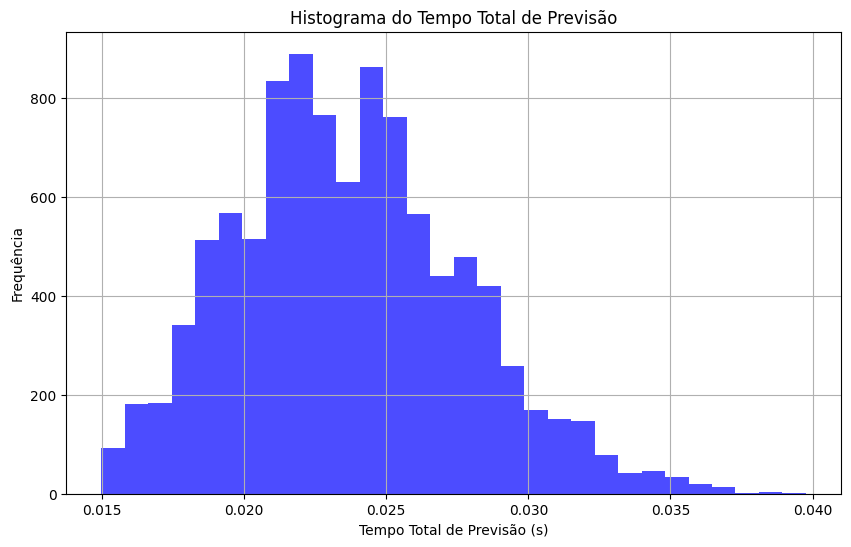

In [207]:

plt.figure(figsize=(10, 6))
plt.hist(df['Tempo_Total_Previsao'], bins=30, color='blue', alpha=0.7)
plt.title('Histograma do Tempo Total de Previsão')
plt.xlabel('Tempo Total de Previsão (s)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


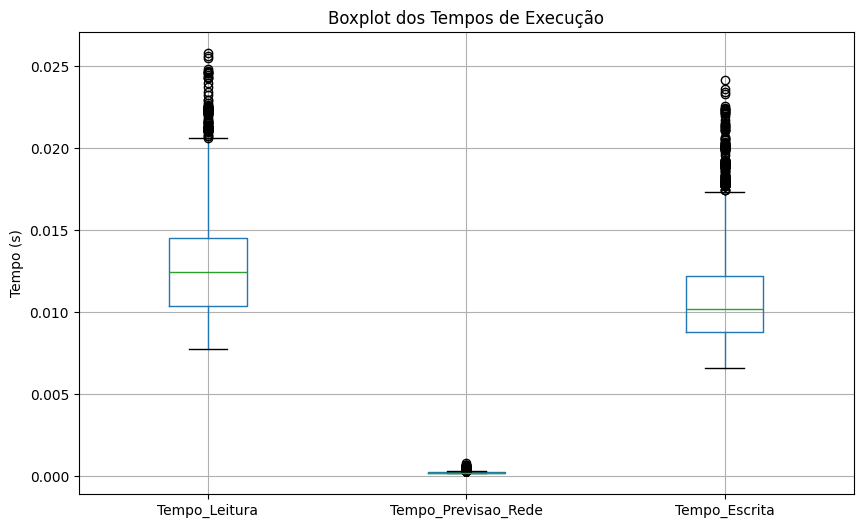

In [208]:
plt.figure(figsize=(10, 6))
df[['Tempo_Leitura', 'Tempo_Previsao_Rede', 'Tempo_Escrita']].boxplot()
plt.title('Boxplot dos Tempos de Execução')
plt.ylabel('Tempo (s)')
plt.grid(True)
plt.show()


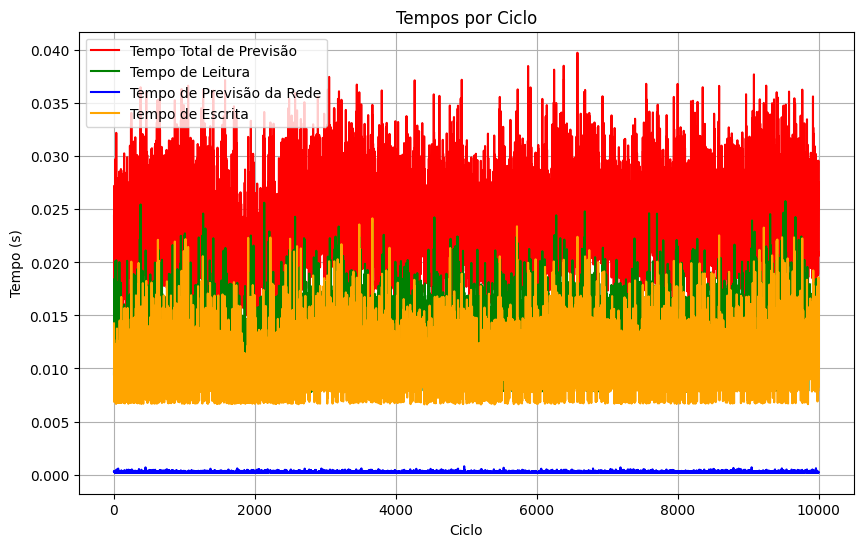

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ciclo'], df['Tempo_Total_Previsao'], label='Tempo Total de Previsão', color='red')
plt.plot(df['Ciclo'], df['Tempo_Leitura'], label='Tempo de Leitura', color='green')
plt.plot(df['Ciclo'], df['Tempo_Previsao_Rede'], label='Tempo de Previsão da Rede', color='blue')
plt.plot(df['Ciclo'], df['Tempo_Escrita'], label='Tempo de Escrita', color='orange')
plt.title('Tempos por Ciclo')
plt.xlabel('Ciclo')
plt.ylabel('Tempo (s)')
plt.legend()
plt.grid(True)
plt.show()


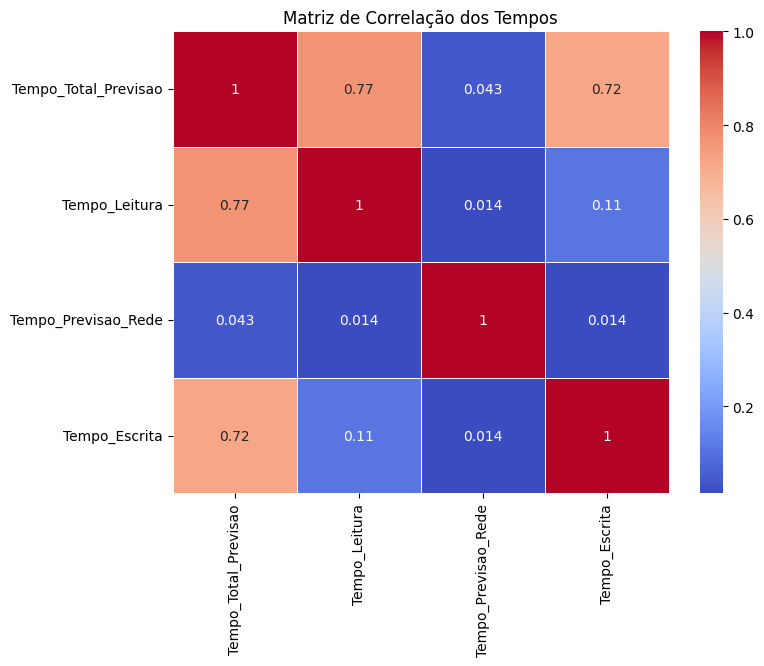

In [210]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Tempo_Total_Previsao', 'Tempo_Leitura', 'Tempo_Previsao_Rede', 'Tempo_Escrita']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação dos Tempos')
plt.show()
